In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train.head()


# 全ての列を表示する設定
pd.set_option('display.max_columns', None)

train.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,y,num_top_amenities,host_experience_years,cancellation_policy_encoded,review_scores_rating_bucket,city_neighbourhood_avg_price
0,6,2.0,Real Bed,1.0,4.0,LA,t,t,f,2016-07-13,f,33.788931,-118.154761,Long Beach,1,Apartment,60.0,Private room,90804,138.0,4,9.4658,0,0,122.221328
1,2,1.0,Real Bed,1.0,1.0,DC,t,t,t,2015-12-30,f,38.934810,-76.978190,Brookland,9,House,100.0,Private room,20018,42.0,10,10.0027,2,2,144.558140
2,2,2.0,Real Bed,1.0,1.0,NYC,t,t,f,2016-05-21,t,40.695118,-73.926240,Bushwick,27,Apartment,83.0,Private room,11221,65.0,9,9.6110,2,2,81.804928
3,2,1.0,Real Bed,1.0,1.0,SF,t,t,t,2012-06-19,t,37.796728,-122.411906,Nob Hill,38,Apartment,95.0,Private room,94133,166.0,9,13.5315,2,2,210.928571
4,2,1.0,Real Bed,1.0,1.0,NYC,t,t,t,2015-03-25,f,40.785050,-73.974691,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,165.0,10,10.7699,2,2,184.027348


### ligthGBMでモデルが重視する特徴量を可視化する



Fold 1/5
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5755
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 29
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 108.709
Early stopping, best iteration is:
[38]	valid_0's rmse: 108.487
RMSE for Fold 1: 108.4869

Fold 2/5
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of catego

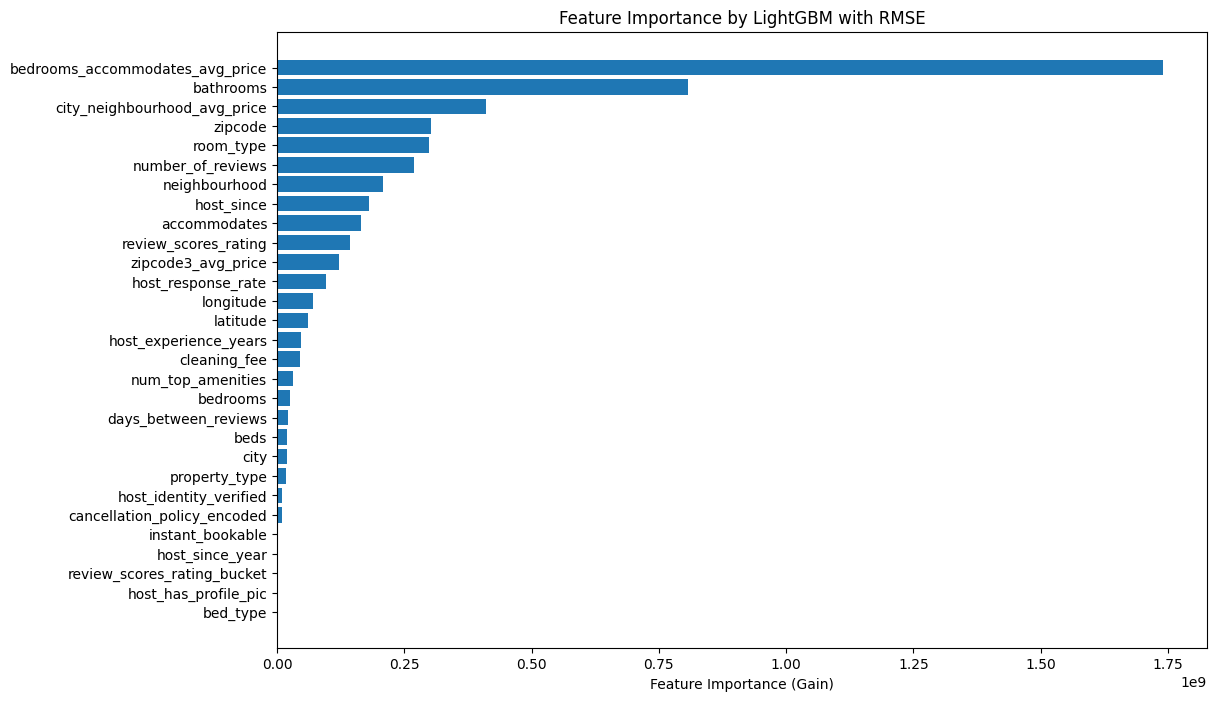

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import os
import pandas as pd

file_path = '/content/drive/My Drive/hotel_service/data/train_0110_6.csv'
train = pd.read_csv(file_path, low_memory=False)

# 特徴量と目的変数の分割
X = train.drop(columns=['y']).copy()
y = train['y'].copy()

# object型のカラムをcategory型に変換
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# カテゴリカル変数リストの作成
categorical_features = list(X.select_dtypes(include='category').columns)

# モデルのパラメータ設定
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 9,
    'num_leaves': 50,
    'seed': 42
}

# KFoldの設定（回帰問題用）
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 特徴量重要度格納用リストとRMSEスコアリスト
feature_importance_values = np.zeros(X.shape[1])
rmse_scores = []

# 保存するディレクトリを指定
save_dir = '/content/drive/My Drive/models/'
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成

# 平均モデルを作成するためのデータ
all_oof_preds = np.zeros(len(y))

# クロスバリデーションのループ
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{kf.n_splits}")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # LightGBMデータセットの作成
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

    # コールバック関数の設定
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=50)
    ]

    # モデルのトレーニング
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_val],
        callbacks=callbacks
    )

    # 特徴量重要度の加算
    feature_importance_values += model.feature_importance(importance_type='gain')

    # RMSEの計算
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    all_oof_preds[val_index] = y_pred
    print(f"RMSE for Fold {fold + 1}: {rmse:.4f}")

# 平均モデルのトレーニング（全データを使用）
final_model = lgb.train(
    params,
    lgb.Dataset(X, label=y, categorical_feature=categorical_features)
)

# 平均モデルの保存
final_model.save_model(os.path.join(save_dir, 'lgbm_final_model_0109_2.txt'))

# RMSEの平均を出力
print(f"\nAverage RMSE across folds: {np.mean(rmse_scores):.4f}")

# 特徴量重要度の平均化
feature_importance_values /= kf.n_splits

# 特徴量重要度の可視化
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(feature_importance_values)
plt.barh(X.columns[sorted_idx], feature_importance_values[sorted_idx])
plt.xlabel('Feature Importance (Gain)')
plt.title('Feature Importance by LightGBM with RMSE')
plt.show()


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


### optunaで最適なパラメータを探す

In [3]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# データの読み込みと前処理
file_path = '/content/drive/My Drive/hotel_service/data/train_0111_1.csv'
train = pd.read_csv(file_path, low_memory=False)

# 特徴量と目的変数の分割
X = train.drop(columns=['y']).copy()
y = train['y'].copy()

# object型のカラムをcategory型に変換
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# カテゴリ変数のリスト作成
categorical_features = list(X.select_dtypes(include='category').columns)

def objective(trial):
    # Optunaでのハイパーパラメータの提案
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-2, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-2, 1.0),
        'seed': 42
    }

    # クロスバリデーション設定
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    # クロスバリデーションループ
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # LightGBMデータセット作成
        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

        # **コールバック関数の設定**
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=50)
        ]

        # モデルのトレーニング (callbacksの適用)
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            callbacks=callbacks
        )

        # RMSE計算とリストへの追加
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)

    # 平均RMSEを返す（修正済み）
    return np.mean(rmse_scores)

# Optunaで最適化実行
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 最適なハイパーパラメータとRMSEの表示
print("Best Hyperparameters:", study.best_params)
print(f"Best RMSE: {study.best_value:.4f}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[I 2025-01-11 06:42:38,031] A new study created in memory with name: no-name-2ec866fc-c2f3-42b1-9761-4fba3e80ee6f
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.sugg

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:42:47,059] Trial 0 finished with value: 108.94310622211712 and parameters: {'learning_rate': 0.06727258441903089, 'num_leaves': 81, 'max_depth': 11, 'min_data_in_leaf': 80, 'feature_fraction': 0.7004094020301693, 'bagging_fraction': 0.9785172354656125, 'bagging_freq': 4, 'lambda_l1': 0.45886388328284605, 'lambda_l2': 0.0450299281376521}. Best is trial 0 with value: 108.94310622211712.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:42:53,052] Trial 1 finished with value: 109.05330760152171 and parameters: {'learning_rate': 0.09758883081303805, 'num_leaves': 84, 'max_depth': 14, 'min_data_in_leaf': 87, 'feature_fraction': 0.7220206045396177, 'bagging_fraction': 0.8112068476753735, 'bagging_freq': 4, 'lambda_l1': 0.014502743596635122, 'lambda_l2': 0.9181016408948156}. Best is trial 0 with value: 108.94310622211712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 107.314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2025-01-11 06:43:02,326] Trial 2 finished with value: 109.31027060370022 and parameters: {'learning_rate': 0.06679504429276427, 'num_leaves': 92, 'max_depth': 15, 'min_data_in_leaf': 71, 'feature_fraction': 0.8337634459181151, 'bagging_fraction': 0.7905684773892644, 'bagging_freq': 1, 'lambda_l1': 0.10154319227894769, 'lambda_l2': 0.29992285931906815}. Best is trial 0 with value: 108.94310622211712.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 131.729
[100]	valid_0's rmse: 117.567
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006108 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:43:06,714] Trial 3 finished with value: 122.48064941047706 and parameters: {'learning_rate': 0.010091315965667137, 'num_leaves': 53, 'max_depth': 12, 'min_data_in_leaf': 50, 'feature_fraction': 0.7291551934999726, 'bagging_fraction': 0.7291948189881077, 'bagging_freq': 4, 'lambda_l1': 0.0296173762304402, 'lambda_l2': 0.7200292233760864}. Best is trial 0 with value: 108.94310622211712.


[100]	valid_0's rmse: 117.129
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 113.241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 107.925
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 117.151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-01-11 06:43:14,856] Trial 4 finished with value: 110.85411425009181 and parameters: {'learning_rate': 0.026446369548978672, 'num_leaves': 53, 'max_depth': 10, 'min_data_in_leaf': 70, 'feature_fraction': 0.952959992332664, 'bagging_fraction': 0.787352984574762, 'bagging_freq': 4, 'lambda_l1': 0.022015482533844267, 'lambda_l2': 0.266584321554322}. Best is trial 0 with value: 108.94310622211712.


[100]	valid_0's rmse: 106.873
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 117.057
[100]	valid_0's rmse: 108.508
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:43:20,411] Trial 5 finished with value: 111.9121625554047 and parameters: {'learning_rate': 0.020579292021593396, 'num_leaves': 65, 'max_depth': 10, 'min_data_in_leaf': 78, 'feature_fraction': 0.7677242129621215, 'bagging_fraction': 0.8878577577990863, 'bagging_freq': 2, 'lambda_l1': 0.025444283759551416, 'lambda_l2': 0.8952638470959593}. Best is trial 0 with value: 108.94310622211712.


[100]	valid_0's rmse: 107.713
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 110.612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 107.55
[LightGBM

[I 2025-01-11 06:43:30,070] Trial 6 finished with value: 109.73627470404168 and parameters: {'learning_rate': 0.03148151547754265, 'num_leaves': 87, 'max_depth': 13, 'min_data_in_leaf': 55, 'feature_fraction': 0.9961411906043118, 'bagging_fraction': 0.7497574666603674, 'bagging_freq': 4, 'lambda_l1': 0.027765384378085303, 'lambda_l2': 0.7432701573222559}. Best is trial 0 with value: 108.94310622211712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.151
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 129.515
[100]	valid_0's rmse: 115.886
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 1

[I 2025-01-11 06:43:35,555] Trial 7 finished with value: 120.2360206540819 and parameters: {'learning_rate': 0.010884906934383681, 'num_leaves': 71, 'max_depth': 13, 'min_data_in_leaf': 59, 'feature_fraction': 0.9786408475868861, 'bagging_fraction': 0.7223129820130982, 'bagging_freq': 4, 'lambda_l1': 0.014560586828800367, 'lambda_l2': 0.10974308593154422}. Best is trial 0 with value: 108.94310622211712.


[100]	valid_0's rmse: 115.168
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 121.507
[100]	valid_0's rmse: 110.616
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:43:45,073] Trial 8 finished with value: 114.27510747120161 and parameters: {'learning_rate': 0.01615076287309931, 'num_leaves': 75, 'max_depth': 15, 'min_data_in_leaf': 90, 'feature_fraction': 0.9161838484192744, 'bagging_fraction': 0.9236101143919009, 'bagging_freq': 2, 'lambda_l1': 0.1707603093022372, 'lambda_l2': 0.023616579987143404}. Best is trial 0 with value: 108.94310622211712.


[100]	valid_0's rmse: 109.803
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 108.157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2025-01-11 06:43:50,428] Trial 9 finished with value: 110.03841863120026 and parameters: {'learning_rate': 0.04907260179082345, 'num_leaves': 73, 'max_depth': 11, 'min_data_in_leaf': 93, 'feature_fraction': 0.8093226055666805, 'bagging_fraction': 0.7548106248645053, 'bagging_freq': 5, 'lambda_l1': 0.5705932231610362, 'lambda_l2': 0.1540503184635649}. Best is trial 0 with value: 108.94310622211712.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.71


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:44:00,303] Trial 10 finished with value: 109.53928870086001 and parameters: {'learning_rate': 0.05581419801122421, 'num_leaves': 97, 'max_depth': 11, 'min_data_in_leaf': 100, 'feature_fraction': 0.8829244122270301, 'bagging_fraction': 0.9970013979604815, 'bagging_freq': 5, 'lambda_l1': 0.7471470930649905, 'lambda_l2': 0.023322310928331424}. Best is trial 0 with value: 108.94310622211712.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_frac

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:44:06,163] Trial 11 finished with value: 108.87713198029148 and parameters: {'learning_rate': 0.09522573744067721, 'num_leaves': 84, 'max_depth': 14, 'min_data_in_leaf': 82, 'feature_fraction': 0.7034369798050975, 'bagging_fraction': 0.8538542550213976, 'bagging_freq': 3, 'lambda_l1': 0.3211365899536597, 'lambda_l2': 0.04612611261844445}. Best is trial 11 with value: 108.87713198029148.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:44:15,070] Trial 12 finished with value: 108.94900472244407 and parameters: {'learning_rate': 0.09859753849976387, 'num_leaves': 82, 'max_depth': 12, 'min_data_in_leaf': 79, 'feature_fraction': 0.774915732988382, 'bagging_fraction': 0.9874869795020486, 'bagging_freq': 3, 'lambda_l1': 0.2888817861116831, 'lambda_l2': 0.044145840653804044}. Best is trial 11 with value: 108.87713198029148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-11 06:44:21,855] Trial 13 finished with value: 108.69064463482778 and parameters: {'learning_rate': 0.07250369451160396, 'num_leaves': 99, 'max_depth': 14, 'min_data_in_leaf': 82, 'feature_fraction': 0.7002189193900166, 'bagging_fraction': 0.9363437043006513, 'bagging_freq': 3, 'lambda_l1': 0.34783890099239306, 'lambda_l2': 0.010838296228348705}. Best is trial 13 with value: 108.69064463482778.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fra

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2025-01-11 06:44:32,177] Trial 14 finished with value: 108.85535808010418 and parameters: {'learning_rate': 0.04308538410448981, 'num_leaves': 100, 'max_depth': 14, 'min_data_in_leaf': 66, 'feature_fraction': 0.7682580235574524, 'bagging_fraction': 0.8659559965163289, 'bagging_freq': 3, 'lambda_l1': 0.26994309937385086, 'lambda_l2': 0.010607818462611683}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 104.997


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2025-01-11 06:44:45,611] Trial 15 finished with value: 108.88834311272906 and parameters: {'learning_rate': 0.04362499941428056, 'num_leaves': 100, 'max_depth': 14, 'min_data_in_leaf': 65, 'feature_fraction': 0.7651759682747964, 'bagging_fraction': 0.9299036183277625, 'bagging_freq': 2, 'lambda_l1': 0.0653077796721825, 'lambda_l2': 0.010250429310854072}. Best is trial 13 with value: 108.69064463482778.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fra

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2025-01-11 06:44:53,489] Trial 16 finished with value: 109.15934211653541 and parameters: {'learning_rate': 0.037767425687981075, 'num_leaves': 93, 'max_depth': 14, 'min_data_in_leaf': 64, 'feature_fraction': 0.8023232687502398, 'bagging_fraction': 0.8784269964478629, 'bagging_freq': 3, 'lambda_l1': 0.18056713617766168, 'lambda_l2': 0.010912604956778831}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.416


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-01-11 06:45:02,005] Trial 17 finished with value: 108.9417562350911 and parameters: {'learning_rate': 0.06641010084734769, 'num_leaves': 92, 'max_depth': 15, 'min_data_in_leaf': 71, 'feature_fraction': 0.745062958545449, 'bagging_fraction': 0.9395254332630284, 'bagging_freq': 1, 'lambda_l1': 0.8990059766788667, 'lambda_l2': 0.020052218525616644}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-01-11 06:45:12,331] Trial 18 finished with value: 109.73298537639467 and parameters: {'learning_rate': 0.03543998988195183, 'num_leaves': 99, 'max_depth': 13, 'min_data_in_leaf': 85, 'feature_fraction': 0.8606534474313321, 'bagging_fraction': 0.8352789077581844, 'bagging_freq': 2, 'lambda_l1': 0.07736720597202773, 'lambda_l2': 0.015063704064291776}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.038


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.667
[100]	valid_0's rmse: 108.202
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2025-01-11 06:45:18,554] Trial 19 finished with value: 109.3384209747937 and parameters: {'learning_rate': 0.054969960164869824, 'num_leaves': 63, 'max_depth': 14, 'min_data_in_leaf': 75, 'feature_fraction': 0.7962264946678771, 'bagging_fraction': 0.8910758227166559, 'bagging_freq': 3, 'lambda_l1': 0.20704609460520462, 'lambda_l2': 0.03496709267366907}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 105.944
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 107.346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Aut

[I 2025-01-11 06:45:28,586] Trial 20 finished with value: 108.98809617935686 and parameters: {'learning_rate': 0.07564963668841065, 'num_leaves': 89, 'max_depth': 15, 'min_data_in_leaf': 65, 'feature_fraction': 0.7509960802274787, 'bagging_fraction': 0.9581794082928223, 'bagging_freq': 2, 'lambda_l1': 0.11996318383293643, 'lambda_l2': 0.014977392154440198}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-01-11 06:45:34,959] Trial 21 finished with value: 109.00019615851747 and parameters: {'learning_rate': 0.07567903241285216, 'num_leaves': 95, 'max_depth': 14, 'min_data_in_leaf': 85, 'feature_fraction': 0.7018608776690182, 'bagging_fraction': 0.8541397626443987, 'bagging_freq': 3, 'lambda_l1': 0.33895543864502214, 'lambda_l2': 0.07433300743316815}. Best is trial 13 with value: 108.69064463482778.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-01-11 06:45:44,548] Trial 22 finished with value: 109.03096423494767 and parameters: {'learning_rate': 0.09198462624236221, 'num_leaves': 100, 'max_depth': 13, 'min_data_in_leaf': 80, 'feature_fraction': 0.7280963779335271, 'bagging_fraction': 0.8486773501847966, 'bagging_freq': 3, 'lambda_l1': 0.3519982975145322, 'lambda_l2': 0.061762627336666306}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-11 06:45:51,695] Trial 23 finished with value: 109.00931393847517 and parameters: {'learning_rate': 0.0821449006129374, 'num_leaves': 78, 'max_depth': 14, 'min_data_in_leaf': 97, 'feature_fraction': 0.7110307497142101, 'bagging_fraction': 0.9015810921713097, 'bagging_freq': 3, 'lambda_l1': 0.2664100667460888, 'lambda_l2': 0.032616375337487374}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-01-11 06:46:00,284] Trial 24 finished with value: 108.96117484054203 and parameters: {'learning_rate': 0.0443443000696963, 'num_leaves': 88, 'max_depth': 13, 'min_data_in_leaf': 73, 'feature_fraction': 0.7418655286472493, 'bagging_fraction': 0.8641766985287609, 'bagging_freq': 3, 'lambda_l1': 0.5088986866086616, 'lambda_l2': 0.015049979784174094}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.183


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 107.536
[LightGBM] [Warning] No further 

[I 2025-01-11 06:46:10,346] Trial 25 finished with value: 109.5250833385002 and parameters: {'learning_rate': 0.054023155303453925, 'num_leaves': 95, 'max_depth': 15, 'min_data_in_leaf': 83, 'feature_fraction': 0.841413142411364, 'bagging_fraction': 0.8223693584425174, 'bagging_freq': 3, 'lambda_l1': 0.0516113111634881, 'lambda_l2': 0.025649333415292373}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 105.904


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 114.522
[100]	valid_0's rmse: 107.765
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006327 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:46:17,114] Trial 26 finished with value: 110.80807106973987 and parameters: {'learning_rate': 0.023686781825165357, 'num_leaves': 86, 'max_depth': 14, 'min_data_in_leaf': 92, 'feature_fraction': 0.7864936697002263, 'bagging_fraction': 0.9131787339474482, 'bagging_freq': 2, 'lambda_l1': 0.14618304534179286, 'lambda_l2': 0.01011046307338294}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.889


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:46:26,924] Trial 27 finished with value: 109.08742543876262 and parameters: {'learning_rate': 0.06432762353166724, 'num_leaves': 89, 'max_depth': 12, 'min_data_in_leaf': 68, 'feature_fraction': 0.7469292785695965, 'bagging_fraction': 0.9609122573808649, 'bagging_freq': 3, 'lambda_l1': 0.2237156820337349, 'lambda_l2': 0.15085022450035748}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.457
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 444

[I 2025-01-11 06:46:32,650] Trial 28 finished with value: 108.935388995389 and parameters: {'learning_rate': 0.08503234806253973, 'num_leaves': 69, 'max_depth': 14, 'min_data_in_leaf': 75, 'feature_fraction': 0.722443321753179, 'bagging_fraction': 0.8699084062528432, 'bagging_freq': 4, 'lambda_l1': 0.38777907561672115, 'lambda_l2': 0.016143345745202268}. Best is trial 13 with value: 108.69064463482778.
<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 107.484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2025-01-11 06:46:42,313] Trial 29 finished with value: 109.19669485813752 and parameters: {'learning_rate': 0.05879039813670789, 'num_leaves': 77, 'max_depth': 13, 'min_data_in_leaf': 58, 'feature_fraction': 0.8224939572516381, 'bagging_fraction': 0.9544376141731499, 'bagging_freq': 5, 'lambda_l1': 0.6247719657605014, 'lambda_l2': 0.05656850977651874}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.858


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-01-11 06:46:48,514] Trial 30 finished with value: 109.3636675547926 and parameters: {'learning_rate': 0.07483984267623059, 'num_leaves': 80, 'max_depth': 15, 'min_data_in_leaf': 82, 'feature_fraction': 0.7028083080155146, 'bagging_fraction': 0.7991482139619414, 'bagging_freq': 2, 'lambda_l1': 0.44498524364319614, 'lambda_l2': 0.04072263635891477}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.301


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2025-01-11 06:46:58,138] Trial 31 finished with value: 108.90708162864905 and parameters: {'learning_rate': 0.04244377390233743, 'num_leaves': 100, 'max_depth': 14, 'min_data_in_leaf': 66, 'feature_fraction': 0.7661982541583028, 'bagging_fraction': 0.9285256568335796, 'bagging_freq': 1, 'lambda_l1': 0.06508712037720403, 'lambda_l2': 0.010814897876171034}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.369


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 111.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-01-11 06:47:11,641] Trial 32 finished with value: 109.40043978756167 and parameters: {'learning_rate': 0.02892704531202725, 'num_leaves': 96, 'max_depth': 14, 'min_data_in_leaf': 61, 'feature_fraction': 0.7611436392839678, 'bagging_fraction': 0.975454230957716, 'bagging_freq': 2, 'lambda_l1': 0.04337214749586428, 'lambda_l2': 0.012585977582062435}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.318


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2025-01-11 06:47:21,010] Trial 33 finished with value: 109.56228422957474 and parameters: {'learning_rate': 0.044077865136919754, 'num_leaves': 92, 'max_depth': 14, 'min_data_in_leaf': 88, 'feature_fraction': 0.8646840971509112, 'bagging_fraction': 0.9051869640526862, 'bagging_freq': 3, 'lambda_l1': 0.12948719266220998, 'lambda_l2': 0.02006147229200292}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.214


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[I 2025-01-11 06:47:28,105] Trial 34 finished with value: 108.7951469544405 and parameters: {'learning_rate': 0.036883090171697726, 'num_leaves': 98, 'max_depth': 15, 'min_data_in_leaf': 62, 'feature_fraction': 0.7232504790304991, 'bagging_fraction': 0.8307542294084925, 'bagging_freq': 1, 'lambda_l1': 0.08364428195830326, 'lambda_l2': 0.029888139326665744}. Best is trial 13 with value: 108.69064463482778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 105.16


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.988
[100]	valid_0's rmse: 106.561
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2025-01-11 06:47:37,543] Trial 35 finished with value: 108.85538550059512 and parameters: {'learning_rate': 0.036129071129895586, 'num_leaves': 83, 'max_depth': 15, 'min_data_in_leaf': 54, 'feature_fraction': 0.7239458376653998, 'bagging_fraction': 0.8228777869776804, 'bagging_freq': 1, 'lambda_l1': 0.10104385213696782, 'lambda_l2': 0.03143362305109087}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 105.219


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.63
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical fe

[I 2025-01-11 06:47:43,837] Trial 36 finished with value: 108.7867422280575 and parameters: {'learning_rate': 0.036501149403665605, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 54, 'feature_fraction': 0.7299572193171784, 'bagging_fraction': 0.8258668013288615, 'bagging_freq': 1, 'lambda_l1': 0.09101953838620984, 'lambda_l2': 0.03345985397323766}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 105.024


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 115.073
[100]	valid_0's rmse: 107.613
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2025-01-11 06:47:53,245] Trial 37 finished with value: 110.59282534973586 and parameters: {'learning_rate': 0.021884485181548157, 'num_leaves': 96, 'max_depth': 15, 'min_data_in_leaf': 50, 'feature_fraction': 0.7390549203396553, 'bagging_fraction': 0.7756949280296773, 'bagging_freq': 1, 'lambda_l1': 0.03799002044022146, 'lambda_l2': 0.018318631517273767}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 106.371


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 119.712
[100]	valid_0's rmse: 109.205
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006439 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:47:59,058] Trial 38 finished with value: 112.80561962661109 and parameters: {'learning_rate': 0.017369275086714514, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 61, 'feature_fraction': 0.716972547603895, 'bagging_fraction': 0.8036444655135259, 'bagging_freq': 1, 'lambda_l1': 0.08573342556893832, 'lambda_l2': 0.1047666537485308}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 108.061


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 111.464
[100]	valid_0's rmse: 107.178
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006256 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:48:07,971] Trial 39 finished with value: 109.40074691337455 and parameters: {'learning_rate': 0.028510535414147012, 'num_leaves': 92, 'max_depth': 15, 'min_data_in_leaf': 54, 'feature_fraction': 0.7839561213714169, 'bagging_fraction': 0.7667092769807007, 'bagging_freq': 1, 'lambda_l1': 0.010461594457101783, 'lambda_l2': 0.39070898162533035}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 105.392


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 110.688
[100]	valid_0's rmse: 107.184
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_row_wise=tru

[I 2025-01-11 06:48:13,228] Trial 40 finished with value: 109.52264545444598 and parameters: {'learning_rate': 0.03262485825770047, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 57, 'feature_fraction': 0.7342434469354984, 'bagging_fraction': 0.8263212884744702, 'bagging_freq': 4, 'lambda_l1': 0.1529125280495315, 'lambda_l2': 0.028415604542872504}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 105.542
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.37
[100]	valid_0's rmse: 106.611
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 11

[I 2025-01-11 06:48:22,146] Trial 41 finished with value: 108.7277948810427 and parameters: {'learning_rate': 0.034759418633109246, 'num_leaves': 94, 'max_depth': 15, 'min_data_in_leaf': 52, 'feature_fraction': 0.7173119010972646, 'bagging_fraction': 0.8375836979341237, 'bagging_freq': 1, 'lambda_l1': 0.1022359083901116, 'lambda_l2': 0.03102581523057093}. Best is trial 13 with value: 108.69064463482778.


[100]	valid_0's rmse: 104.822


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.844
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

[I 2025-01-11 06:48:28,884] Trial 42 finished with value: 108.60903102808663 and parameters: {'learning_rate': 0.03947294763827849, 'num_leaves': 98, 'max_depth': 15, 'min_data_in_leaf': 51, 'feature_fraction': 0.7203863442272397, 'bagging_fraction': 0.8385729040537657, 'bagging_freq': 1, 'lambda_l1': 0.11861516194174072, 'lambda_l2': 0.07312615239969936}. Best is trial 42 with value: 108.60903102808663.


[100]	valid_0's rmse: 104.97
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 110.051
[100]	valid_0's rmse: 106.76
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

[I 2025-01-11 06:48:38,168] Trial 43 finished with value: 108.80327093293667 and parameters: {'learning_rate': 0.03235359731831945, 'num_leaves': 94, 'max_depth': 15, 'min_data_in_leaf': 51, 'feature_fraction': 0.7169743468777263, 'bagging_fraction': 0.839503738688344, 'bagging_freq': 1, 'lambda_l1': 0.1162804024215625, 'lambda_l2': 0.05389229125630904}. Best is trial 42 with value: 108.60903102808663.


[100]	valid_0's rmse: 104.869


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 112.726
[100]	valid_0's rmse: 107.495
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009513 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:48:44,472] Trial 44 finished with value: 109.8781585832011 and parameters: {'learning_rate': 0.025653734376547662, 'num_leaves': 90, 'max_depth': 15, 'min_data_in_leaf': 55, 'feature_fraction': 0.9106363124396883, 'bagging_fraction': 0.8114850815501589, 'bagging_freq': 1, 'lambda_l1': 0.08043450049008509, 'lambda_l2': 0.13766490129644962}. Best is trial 42 with value: 108.60903102808663.


[100]	valid_0's rmse: 105.799


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 106.946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse:

[I 2025-01-11 06:48:54,219] Trial 45 finished with value: 108.48965352540283 and parameters: {'learning_rate': 0.04928757780744015, 'num_leaves': 98, 'max_depth': 15, 'min_data_in_leaf': 52, 'feature_fraction': 0.7289426932238688, 'bagging_fraction': 0.7880754218927369, 'bagging_freq': 1, 'lambda_l1': 0.05300303426379898, 'lambda_l2': 0.0765040560373626}. Best is trial 45 with value: 108.48965352540283.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 104.899


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.568
[100]	valid_0's rmse: 107.422
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2025-01-11 06:49:00,598] Trial 46 finished with value: 108.66864828158093 and parameters: {'learning_rate': 0.04826990223288321, 'num_leaves': 86, 'max_depth': 15, 'min_data_in_leaf': 52, 'feature_fraction': 0.7555013209024606, 'bagging_fraction': 0.7378370862128564, 'bagging_freq': 1, 'lambda_l1': 0.03245076862059609, 'lambda_l2': 0.07835073246137175}. Best is trial 45 with value: 108.48965352540283.


[100]	valid_0's rmse: 105.517


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 107.327
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categori

[I 2025-01-11 06:49:09,588] Trial 47 finished with value: 108.79884038847722 and parameters: {'learning_rate': 0.05109886138711664, 'num_leaves': 86, 'max_depth': 15, 'min_data_in_leaf': 57, 'feature_fraction': 0.7545719818398777, 'bagging_fraction': 0.700986304674262, 'bagging_freq': 1, 'lambda_l1': 0.03361662049473688, 'lambda_l2': 0.08146381138743246}. Best is trial 45 with value: 108.48965352540283.


[100]	valid_0's rmse: 105.662


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 107.197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 106.958
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number 

[I 2025-01-11 06:49:16,496] Trial 48 finished with value: 108.46400202078428 and parameters: {'learning_rate': 0.04879584979536084, 'num_leaves': 91, 'max_depth': 15, 'min_data_in_leaf': 52, 'feature_fraction': 0.7083987309609161, 'bagging_fraction': 0.7859059784031809, 'bagging_freq': 1, 'lambda_l1': 0.023574234009606995, 'lambda_l2': 0.22878420709405534}. Best is trial 48 with value: 108.46400202078428.


[100]	valid_0's rmse: 104.75


<ipython-input-3-8f18b233c054>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
<ipython-input-3-8f18b233c054>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
<ipython-input-3-8f18b233c054>:36: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-01-11 06:49:24,356] Trial 49 finished with value: 108.84075317427221 and parameters: {'learning_rate': 0.06168249775187647, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 50, 'feature_fraction': 0.7003660337674663, 'bagging_fraction': 0.7418719319416712, 'bagging_freq': 2, 'lambda_l1': 0.020334936408825836, 'lambda_l2': 0.242220402323624}. Best is trial 48 with value: 108.46400202078428.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 104.938
Best Hyperparameters: {'learning_rate': 0.04879584979536084, 'num_leaves': 91, 'max_depth': 15, 'min_data_in_leaf': 52, 'feature_fraction': 0.708

### 最適なパラメータを使用してモデルをトレーニングする

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 106.836
Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 106.323

Final RMSE on validation set: 106.3232
モデルが正常に保存されました: /content/drive/My Drive/models/lgbm_final_model_0111_1.txt


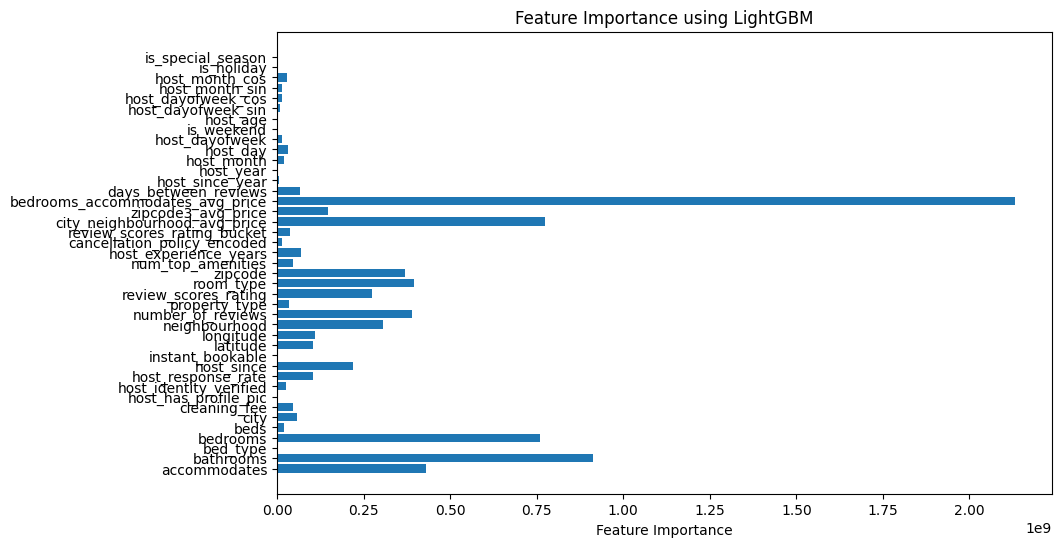

In [4]:
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 保存用のディレクトリ作成
save_dir = '/content/drive/My Drive/models/'
os.makedirs(save_dir, exist_ok=True)

# 最適なパラメータを直接定義
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.04879584979536084,
    'num_leaves': 91,
    'max_depth': 15,
    'min_data_in_leaf': 52,
    'feature_fraction': 0.7083987309609161,
    'bagging_fraction': 0.7859059784031809,
    'bagging_freq': 1,
    'lambda_l1': 0.023574234009606995,
    'lambda_l2': 0.22878420709405534,
    'seed': 42
}

# データを訓練データと検証データに分割（80%: 訓練, 20%: 検証）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMデータセットの作成
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

# コールバックの設定（過学習防止のためearly_stopping_roundsを適用）
callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True),
    lgb.log_evaluation(period=100)  # 100イテレーションごとにログ表示
]

# モデルのトレーニング（verbose_evalをcallbacksで管理）
final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_val],
    callbacks=callbacks
)

# **RMSEの計算**
y_pred = final_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"\nFinal RMSE on validation set: {rmse:.4f}")

# モデルの保存
model_path = os.path.join(save_dir, 'lgbm_final_model_0111_1.txt')
final_model.save_model(model_path)
print(f"モデルが正常に保存されました: {model_path}")

# 特徴量重要度の可視化
feature_importance_values = final_model.feature_importance(importance_type='gain')
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance_values)
plt.xlabel('Feature Importance')
plt.title('Feature Importance using LightGBM')
plt.show()


### カテゴリ変数は'missing'に、数値は中央値で補完する

In [5]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# データの読み込みと前処理
file_path = '/content/drive/My Drive/hotel_service/data/train_0111_1.csv'
train = pd.read_csv(file_path, low_memory=False)

# 特徴量と目的変数の分割
X = train.drop(columns=['y']).copy()
y = train['y'].copy()

# カテゴリ変数のリスト作成
categorical_features = list(X.select_dtypes(include='object').columns)

# ✅ NaNの処理を分けて修正
# カテゴリ変数: "missing"に補完し、category型に変換
for col in categorical_features:
    X[col] = X[col].fillna("missing").astype('category')

# 数値変数: 中央値で補完
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())

# ✅ OptunaのObjective関数
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 1.0),
        'seed': 42
    }

    # ✅ クロスバリデーション設定
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    # ✅ クロスバリデーションループ
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # ✅ LightGBMデータセットの作成
        lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

        # ✅ コールバック関数の適用
        callbacks = [
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=50)
        ]

        # ✅ モデルのトレーニング (コールバック含む)
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            callbacks=callbacks
        )

        # ✅ RMSEの計算
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # ✅ 平均RMSEを返す
    return np.mean(rmse_scores)

# ✅ Optunaで最適化の実行
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# ✅ 最適なハイパーパラメータとRMSEの表示
print("Best Hyperparameters:", study.best_params)
print(f"Best RMSE: {study.best_value:.4f}")


[I 2025-01-11 06:53:44,642] A new study created in memory with name: no-name-069fff70-7dee-484a-9240-2aaf44d8712f
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_f

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.52
[100]	valid_0's rmse: 109.81
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011581 seconds.
You can set `force_col_wise=true`

[I 2025-01-11 06:53:49,200] Trial 0 finished with value: 110.12036664400898 and parameters: {'learning_rate': 0.07537865709333319, 'num_leaves': 41, 'max_depth': 13, 'min_data_in_leaf': 30, 'feature_fraction': 0.876233790848256, 'bagging_fraction': 0.8519648071827031, 'bagging_freq': 1, 'lambda_l1': 0.03687280506250228, 'lambda_l2': 0.015215279303868639}. Best is trial 0 with value: 110.12036664400898.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.242
[100]	valid_0's rmse: 108.869
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2025-01-11 06:53:56,611] Trial 1 finished with value: 110.11265318975009 and parameters: {'learning_rate': 0.05130307263709273, 'num_leaves': 35, 'max_depth': 11, 'min_data_in_leaf': 30, 'feature_fraction': 0.8745568271111015, 'bagging_fraction': 0.9747147638167614, 'bagging_freq': 1, 'lambda_l1': 0.03090490609596671, 'lambda_l2': 0.23826591901884267}. Best is trial 1 with value: 110.11265318975009.


[100]	valid_0's rmse: 107.377
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.575
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 110.334
[100]	valid_0's rmse: 1

[I 2025-01-11 06:54:01,209] Trial 2 finished with value: 110.15324479076212 and parameters: {'learning_rate': 0.075080960815815, 'num_leaves': 31, 'max_depth': 13, 'min_data_in_leaf': 37, 'feature_fraction': 0.800030854601355, 'bagging_fraction': 0.9045504263457185, 'bagging_freq': 5, 'lambda_l1': 0.19893992669665367, 'lambda_l2': 0.05045159770384044}. Best is trial 1 with value: 110.11265318975009.


[100]	valid_0's rmse: 107.636
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.445
[100]	valid_0's rmse: 109.601
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 109.912
[100]	valid_0's rmse: 109.909
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be 

[I 2025-01-11 06:54:07,010] Trial 3 finished with value: 109.92735953088172 and parameters: {'learning_rate': 0.06112819498916406, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 34, 'feature_fraction': 0.8965325370133694, 'bagging_fraction': 0.8718535474469925, 'bagging_freq': 3, 'lambda_l1': 0.2028651586301038, 'lambda_l2': 0.002037036606586344}. Best is trial 3 with value: 109.92735953088172.


[100]	valid_0's rmse: 106.295
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.44
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number o

[I 2025-01-11 06:54:15,556] Trial 4 finished with value: 110.41005812213541 and parameters: {'learning_rate': 0.07150023516435836, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 30, 'feature_fraction': 0.9902792715643569, 'bagging_fraction': 0.8063790356346561, 'bagging_freq': 5, 'lambda_l1': 0.0038937617998235645, 'lambda_l2': 0.0010145406283549876}. Best is trial 3 with value: 109.92735953088172.


[100]	valid_0's rmse: 107.733
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.461
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 110.242
[100]	valid_0's rmse: 110.707
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of

[I 2025-01-11 06:54:20,447] Trial 5 finished with value: 110.56357006779137 and parameters: {'learning_rate': 0.09167388907220161, 'num_leaves': 35, 'max_depth': 14, 'min_data_in_leaf': 30, 'feature_fraction': 0.9915028000915298, 'bagging_fraction': 0.8657228613944771, 'bagging_freq': 3, 'lambda_l1': 0.6537519584952145, 'lambda_l2': 0.0022999795891280434}. Best is trial 3 with value: 109.92735953088172.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.278
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007820 second

[I 2025-01-11 06:54:28,604] Trial 6 finished with value: 110.47957266437145 and parameters: {'learning_rate': 0.0810526732109673, 'num_leaves': 47, 'max_depth': 11, 'min_data_in_leaf': 29, 'feature_fraction': 0.9481317116735573, 'bagging_fraction': 0.8041660143886576, 'bagging_freq': 4, 'lambda_l1': 0.018240816096443662, 'lambda_l2': 0.1379256801988903}. Best is trial 3 with value: 109.92735953088172.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.413
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004419 second

[I 2025-01-11 06:54:40,368] Trial 7 finished with value: 110.06351920331568 and parameters: {'learning_rate': 0.09758726251717627, 'num_leaves': 38, 'max_depth': 13, 'min_data_in_leaf': 30, 'feature_fraction': 0.9061703323133279, 'bagging_fraction': 0.9715139128062376, 'bagging_freq': 2, 'lambda_l1': 0.18981632544483537, 'lambda_l2': 0.18101102995954904}. Best is trial 3 with value: 109.92735953088172.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.182
[100]	valid_0's rmse: 109.304
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

[I 2025-01-11 06:54:45,306] Trial 8 finished with value: 110.43469709530714 and parameters: {'learning_rate': 0.05655053652661941, 'num_leaves': 35, 'max_depth': 13, 'min_data_in_leaf': 23, 'feature_fraction': 0.9823912307020544, 'bagging_fraction': 0.8875710655861075, 'bagging_freq': 5, 'lambda_l1': 0.0018708375348599877, 'lambda_l2': 0.9531227935182263}. Best is trial 3 with value: 109.92735953088172.


[100]	valid_0's rmse: 107.513
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.981
[100]	valid_0's rmse: 109.063
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 111.339
[100]	valid_0's rmse: 110.626
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be 

[I 2025-01-11 06:54:49,837] Trial 9 finished with value: 110.24725270779648 and parameters: {'learning_rate': 0.052413383049764624, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 42, 'feature_fraction': 0.9305074816129785, 'bagging_fraction': 0.8421125510384317, 'bagging_freq': 1, 'lambda_l1': 0.4993199425387724, 'lambda_l2': 0.05604302470225379}. Best is trial 3 with value: 109.92735953088172.


[100]	valid_0's rmse: 106.944
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.249
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 110.119
[100]	valid_0's rmse: 1

[I 2025-01-11 06:54:58,612] Trial 10 finished with value: 109.99397688964034 and parameters: {'learning_rate': 0.0622691381000673, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 49, 'feature_fraction': 0.8307663604813111, 'bagging_fraction': 0.9311714980667914, 'bagging_freq': 3, 'lambda_l1': 0.07517157321757953, 'lambda_l2': 0.00684492146428189}. Best is trial 3 with value: 109.92735953088172.


[100]	valid_0's rmse: 106.767
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.419
[100]	valid_0's rmse: 109.008
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:55:04,524] Trial 11 finished with value: 109.81902144103336 and parameters: {'learning_rate': 0.06044747959699818, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 50, 'feature_fraction': 0.8183479625327864, 'bagging_fraction': 0.9328955471148312, 'bagging_freq': 3, 'lambda_l1': 0.08637357167249517, 'lambda_l2': 0.005052294848275961}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.402
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.314
[100]	valid_0's rmse: 109.242
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in

[I 2025-01-11 06:55:13,140] Trial 12 finished with value: 109.93910569105849 and parameters: {'learning_rate': 0.0611203878861591, 'num_leaves': 44, 'max_depth': 15, 'min_data_in_leaf': 50, 'feature_fraction': 0.8328156772299466, 'bagging_fraction': 0.9321338326273334, 'bagging_freq': 3, 'lambda_l1': 0.11535889899665318, 'lambda_l2': 0.0030646092044191685}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 107.036
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.639
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score

[I 2025-01-11 06:55:18,520] Trial 13 finished with value: 110.0830071789037 and parameters: {'learning_rate': 0.06396788629781873, 'num_leaves': 50, 'max_depth': 10, 'min_data_in_leaf': 41, 'feature_fraction': 0.8541615022739331, 'bagging_fraction': 0.9303879900299834, 'bagging_freq': 2, 'lambda_l1': 0.011912177901551739, 'lambda_l2': 0.008506491757736491}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fra

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.2
[100]	valid_0's rmse: 109.842
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of

[I 2025-01-11 06:55:27,500] Trial 14 finished with value: 110.1489560530097 and parameters: {'learning_rate': 0.0665709316409876, 'num_leaves': 46, 'max_depth': 14, 'min_data_in_leaf': 44, 'feature_fraction': 0.902199791360735, 'bagging_fraction': 0.995415383064821, 'bagging_freq': 4, 'lambda_l1': 0.32909568286629914, 'lambda_l2': 0.0011773874599269487}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.942
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.157
[100]	valid_0's rmse: 109.752
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 1

[I 2025-01-11 06:55:32,734] Trial 15 finished with value: 110.23646295781766 and parameters: {'learning_rate': 0.0564536300994511, 'num_leaves': 43, 'max_depth': 12, 'min_data_in_leaf': 37, 'feature_fraction': 0.8005709608304041, 'bagging_fraction': 0.8930375617971074, 'bagging_freq': 2, 'lambda_l1': 0.9757155729361106, 'lambda_l2': 0.004393334575558907}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 107.009
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.645
[100]	valid_0's rmse: 109.288
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in

[I 2025-01-11 06:55:42,007] Trial 16 finished with value: 110.09741695578084 and parameters: {'learning_rate': 0.056323311494199585, 'num_leaves': 50, 'max_depth': 15, 'min_data_in_leaf': 46, 'feature_fraction': 0.9413798277271805, 'bagging_fraction': 0.9147011435077042, 'bagging_freq': 4, 'lambda_l1': 0.06542842018303163, 'lambda_l2': 0.017864230045330654}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.941
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.374
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number 

[I 2025-01-11 06:55:47,251] Trial 17 finished with value: 109.89745590175411 and parameters: {'learning_rate': 0.06645172742098641, 'num_leaves': 45, 'max_depth': 12, 'min_data_in_leaf': 34, 'feature_fraction': 0.8730502325268253, 'bagging_fraction': 0.8741129506331984, 'bagging_freq': 4, 'lambda_l1': 0.007621875821638755, 'lambda_l2': 0.0018243799696504531}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.813
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.589
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 110.144
[100]	valid_0's rmse: 1

[I 2025-01-11 06:55:55,052] Trial 18 finished with value: 109.99973948902581 and parameters: {'learning_rate': 0.08455124652166998, 'num_leaves': 44, 'max_depth': 12, 'min_data_in_leaf': 23, 'feature_fraction': 0.8295303328452651, 'bagging_fraction': 0.9635541597277051, 'bagging_freq': 4, 'lambda_l1': 0.005808006254472251, 'lambda_l2': 0.007160994099504614}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.209
[100]	valid_0's rmse: 109.315
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

[I 2025-01-11 06:56:00,393] Trial 19 finished with value: 109.88504176338014 and parameters: {'learning_rate': 0.06767553068352174, 'num_leaves': 47, 'max_depth': 12, 'min_data_in_leaf': 39, 'feature_fraction': 0.8538357651513184, 'bagging_fraction': 0.8279012780468367, 'bagging_freq': 4, 'lambda_l1': 0.0012981176908541093, 'lambda_l2': 0.018186933340211528}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_f

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.577
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

[I 2025-01-11 06:56:08,755] Trial 20 finished with value: 110.14608462407004 and parameters: {'learning_rate': 0.07026672791355777, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 47, 'feature_fraction': 0.8476417998953624, 'bagging_fraction': 0.8264409602942895, 'bagging_freq': 3, 'lambda_l1': 0.0014112582616548673, 'lambda_l2': 0.021720931397972258}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.743
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.426
[100]	valid_0's rmse: 109.571
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:56:13,917] Trial 21 finished with value: 110.13457736134373 and parameters: {'learning_rate': 0.06804223325408325, 'num_leaves': 45, 'max_depth': 12, 'min_data_in_leaf': 34, 'feature_fraction': 0.8670126166984199, 'bagging_fraction': 0.8250244667408584, 'bagging_freq': 4, 'lambda_l1': 0.0032505125199363324, 'lambda_l2': 0.010788691332902433}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_f

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.566
[100]	valid_0's rmse: 109.349
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2025-01-11 06:56:21,804] Trial 22 finished with value: 110.02847190679931 and parameters: {'learning_rate': 0.06547836218761889, 'num_leaves': 42, 'max_depth': 12, 'min_data_in_leaf': 39, 'feature_fraction': 0.8226546083224668, 'bagging_fraction': 0.8728659678942086, 'bagging_freq': 4, 'lambda_l1': 0.010678291661843798, 'lambda_l2': 0.0032747566333550682}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_f

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.464
[100]	valid_0's rmse: 108.852
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003723 seconds.
You can set `force_row_wise=tru

[I 2025-01-11 06:56:26,660] Trial 23 finished with value: 109.92743365172824 and parameters: {'learning_rate': 0.05863042170214281, 'num_leaves': 46, 'max_depth': 11, 'min_data_in_leaf': 26, 'feature_fraction': 0.8484917644674379, 'bagging_fraction': 0.8281222664983077, 'bagging_freq': 5, 'lambda_l1': 0.0054415152617864155, 'lambda_l2': 0.04026526263278047}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 107.337
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.546
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number 

[I 2025-01-11 06:56:32,228] Trial 24 finished with value: 109.96549226445447 and parameters: {'learning_rate': 0.0742329804357773, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 20, 'feature_fraction': 0.8663339573407424, 'bagging_fraction': 0.9468607048491694, 'bagging_freq': 4, 'lambda_l1': 0.0010990010689006804, 'lambda_l2': 0.005615689717254838}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.727
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

[I 2025-01-11 06:56:39,990] Trial 25 finished with value: 109.85221843656663 and parameters: {'learning_rate': 0.08187926265343075, 'num_leaves': 40, 'max_depth': 14, 'min_data_in_leaf': 33, 'feature_fraction': 0.8150629229202473, 'bagging_fraction': 0.8530066329455427, 'bagging_freq': 2, 'lambda_l1': 0.0023000506620216277, 'lambda_l2': 0.0014145411401466025}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.995
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.715
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 110.114
[100]	valid_0's rmse: 1

[I 2025-01-11 06:56:45,053] Trial 26 finished with value: 110.05946048831227 and parameters: {'learning_rate': 0.07975069229942021, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 43, 'feature_fraction': 0.8142863498528692, 'bagging_fraction': 0.8521567746774211, 'bagging_freq': 2, 'lambda_l1': 0.0022816457452643785, 'lambda_l2': 0.08328497984852445}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.898
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.991
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score

[I 2025-01-11 06:56:53,467] Trial 27 finished with value: 110.0597792261793 and parameters: {'learning_rate': 0.09019760029231935, 'num_leaves': 40, 'max_depth': 15, 'min_data_in_leaf': 38, 'feature_fraction': 0.812281102152111, 'bagging_fraction': 0.9164935989274244, 'bagging_freq': 2, 'lambda_l1': 0.026623186811505273, 'lambda_l2': 0.02388798449799991}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fract

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.904
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

[I 2025-01-11 06:56:58,440] Trial 28 finished with value: 110.12531755690088 and parameters: {'learning_rate': 0.07955498585237913, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 46, 'feature_fraction': 0.840503389037438, 'bagging_fraction': 0.8427639461286109, 'bagging_freq': 2, 'lambda_l1': 0.0027642363056791693, 'lambda_l2': 0.012054195536961819}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.12
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds

[I 2025-01-11 06:57:08,840] Trial 29 finished with value: 110.11937794641301 and parameters: {'learning_rate': 0.08577748132098055, 'num_leaves': 42, 'max_depth': 15, 'min_data_in_leaf': 36, 'feature_fraction': 0.8870645037723704, 'bagging_fraction': 0.8575416272481754, 'bagging_freq': 3, 'lambda_l1': 0.06078504983928308, 'lambda_l2': 0.004053455921605318}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fra

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.827
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

[I 2025-01-11 06:57:13,459] Trial 30 finished with value: 109.97998383727744 and parameters: {'learning_rate': 0.07151296045886521, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 40, 'feature_fraction': 0.8184347951422039, 'bagging_fraction': 0.8155306993774742, 'bagging_freq': 1, 'lambda_l1': 0.0010289164891699567, 'lambda_l2': 0.01436216084683322}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.88
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.539
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 110.235
[100]	valid_0's rmse: 1

[I 2025-01-11 06:57:21,844] Trial 31 finished with value: 109.95860133676804 and parameters: {'learning_rate': 0.06798534623529132, 'num_leaves': 45, 'max_depth': 13, 'min_data_in_leaf': 33, 'feature_fraction': 0.8585887361168382, 'bagging_fraction': 0.8792661414279062, 'bagging_freq': 3, 'lambda_l1': 0.006277531620812429, 'lambda_l2': 0.001795013786648829}. Best is trial 11 with value: 109.81902144103336.
<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fr

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.712
[100]	valid_0's rmse: 109.429
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

[I 2025-01-11 06:57:27,144] Trial 32 finished with value: 109.9913812875426 and parameters: {'learning_rate': 0.05371268939083402, 'num_leaves': 48, 'max_depth': 12, 'min_data_in_leaf': 32, 'feature_fraction': 0.8827606613111922, 'bagging_fraction': 0.8460140934399821, 'bagging_freq': 4, 'lambda_l1': 0.0018713904190177178, 'lambda_l2': 0.00172701858834325}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 106.798
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.54
[100]	valid_0's rmse: 109.129
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [In

[I 2025-01-11 06:57:34,155] Trial 33 finished with value: 110.22864566587603 and parameters: {'learning_rate': 0.06361633467055615, 'num_leaves': 31, 'max_depth': 11, 'min_data_in_leaf': 27, 'feature_fraction': 0.839857467768107, 'bagging_fraction': 0.9008921840362634, 'bagging_freq': 3, 'lambda_l1': 0.039463502790098276, 'lambda_l2': 0.0012712001780757287}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 107.532


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.999
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004931 second

[I 2025-01-11 06:57:40,017] Trial 34 finished with value: 109.95109195772056 and parameters: {'learning_rate': 0.076172847485996, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.872352663988888, 'bagging_fraction': 0.8627149059527485, 'bagging_freq': 5, 'lambda_l1': 0.009602403602689767, 'lambda_l2': 0.002583694836278698}. Best is trial 11 with value: 109.81902144103336.


[100]	valid_0's rmse: 107.429
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.361
[100]	valid_0's rmse: 109.157
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:57:44,711] Trial 35 finished with value: 109.71888341639556 and parameters: {'learning_rate': 0.05972605204754353, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 32, 'feature_fraction': 0.8041716650665782, 'bagging_fraction': 0.8334566576524591, 'bagging_freq': 1, 'lambda_l1': 0.004256391885814784, 'lambda_l2': 0.0045419615845287715}. Best is trial 35 with value: 109.71888341639556.


[100]	valid_0's rmse: 106.382
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.532
[100]	valid_0's rmse: 109.292
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in

[I 2025-01-11 06:57:52,639] Trial 36 finished with value: 109.98567380224411 and parameters: {'learning_rate': 0.059508753494008075, 'num_leaves': 41, 'max_depth': 14, 'min_data_in_leaf': 32, 'feature_fraction': 0.8063209955619197, 'bagging_fraction': 0.8346071224124747, 'bagging_freq': 1, 'lambda_l1': 0.004077353052617912, 'lambda_l2': 0.005103716473483376}. Best is trial 35 with value: 109.71888341639556.


[100]	valid_0's rmse: 106.851
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.814
[100]	valid_0's rmse: 108.894
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:57:57,363] Trial 37 finished with value: 109.70736088485368 and parameters: {'learning_rate': 0.05000166625670972, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.8176147914914488, 'bagging_fraction': 0.8130720575526802, 'bagging_freq': 1, 'lambda_l1': 0.017399383760806707, 'lambda_l2': 0.008935902080518608}. Best is trial 37 with value: 109.70736088485368.


[100]	valid_0's rmse: 106.452
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.905
[100]	valid_0's rmse: 109.142
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 1

[I 2025-01-11 06:58:04,897] Trial 38 finished with value: 110.2705910268517 and parameters: {'learning_rate': 0.05360672212151111, 'num_leaves': 33, 'max_depth': 13, 'min_data_in_leaf': 26, 'feature_fraction': 0.8223707424132805, 'bagging_fraction': 0.8133671918214556, 'bagging_freq': 1, 'lambda_l1': 0.021044550022794654, 'lambda_l2': 0.009055592269090675}. Best is trial 37 with value: 109.70736088485368.


[100]	valid_0's rmse: 106.937
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.792
[100]	valid_0's rmse: 108.638
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 1

[I 2025-01-11 06:58:09,653] Trial 39 finished with value: 109.71709961945695 and parameters: {'learning_rate': 0.05054913436530874, 'num_leaves': 49, 'max_depth': 14, 'min_data_in_leaf': 28, 'feature_fraction': 0.8093284768818887, 'bagging_fraction': 0.8043926380485684, 'bagging_freq': 1, 'lambda_l1': 0.0152855096472712, 'lambda_l2': 0.0030605405214037457}. Best is trial 37 with value: 109.70736088485368.


[100]	valid_0's rmse: 106.487
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.799
[100]	valid_0's rmse: 108.954
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.156974
[50]	valid_0's rmse: 1

[I 2025-01-11 06:58:14,388] Trial 40 finished with value: 109.78708461849745 and parameters: {'learning_rate': 0.05066722252069063, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.8052749575091803, 'bagging_fraction': 0.8067994762755072, 'bagging_freq': 1, 'lambda_l1': 0.01612058343742375, 'lambda_l2': 0.9016043905082518}. Best is trial 37 with value: 109.70736088485368.


[100]	valid_0's rmse: 106.707


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.497
[100]	valid_0's rmse: 108.291
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015593 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:58:21,824] Trial 41 finished with value: 109.6832952034869 and parameters: {'learning_rate': 0.0502794451302861, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.8069810904717585, 'bagging_fraction': 0.8018555644116381, 'bagging_freq': 1, 'lambda_l1': 0.014842822230545965, 'lambda_l2': 0.410303107648115}. Best is trial 41 with value: 109.6832952034869.


[100]	valid_0's rmse: 106.734
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.694
[100]	valid_0's rmse: 108.541
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:58:26,542] Trial 42 finished with value: 109.78662357811444 and parameters: {'learning_rate': 0.05011396368870156, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.8004730189487395, 'bagging_fraction': 0.8018512512189571, 'bagging_freq': 1, 'lambda_l1': 0.017038254256902356, 'lambda_l2': 0.833283688364137}. Best is trial 41 with value: 109.6832952034869.


[100]	valid_0's rmse: 106.93
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.781
[100]	valid_0's rmse: 108.928
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:58:34,256] Trial 43 finished with value: 109.75289597537467 and parameters: {'learning_rate': 0.05055366866946024, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 24, 'feature_fraction': 0.8068554500201024, 'bagging_fraction': 0.8013351856164743, 'bagging_freq': 1, 'lambda_l1': 0.015251949699751794, 'lambda_l2': 0.45251286520746536}. Best is trial 41 with value: 109.6832952034869.


[100]	valid_0's rmse: 106.85
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.49
[100]	valid_0's rmse: 108.819
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [In

[I 2025-01-11 06:58:39,009] Trial 44 finished with value: 109.70661003670803 and parameters: {'learning_rate': 0.05249874655012654, 'num_leaves': 49, 'max_depth': 13, 'min_data_in_leaf': 24, 'feature_fraction': 0.8255119440955239, 'bagging_fraction': 0.8155250919003237, 'bagging_freq': 1, 'lambda_l1': 0.039122796039915586, 'lambda_l2': 0.4469405519165086}. Best is trial 41 with value: 109.6832952034869.


[100]	valid_0's rmse: 106.819
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.68
[100]	valid_0's rmse: 108.692
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [In

[I 2025-01-11 06:58:46,904] Trial 45 finished with value: 109.65709881702142 and parameters: {'learning_rate': 0.0526846328898668, 'num_leaves': 48, 'max_depth': 13, 'min_data_in_leaf': 24, 'feature_fraction': 0.8300790359859321, 'bagging_fraction': 0.8138646960687151, 'bagging_freq': 1, 'lambda_l1': 0.042458409594650005, 'lambda_l2': 0.4146121903665976}. Best is trial 45 with value: 109.65709881702142.


[100]	valid_0's rmse: 106.691


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.905
[100]	valid_0's rmse: 109.084
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008903 seconds.
You can set `force_col_wise=tru

[I 2025-01-11 06:58:51,643] Trial 46 finished with value: 109.96089010280882 and parameters: {'learning_rate': 0.05284959231944435, 'num_leaves': 48, 'max_depth': 13, 'min_data_in_leaf': 20, 'feature_fraction': 0.8352058773566986, 'bagging_fraction': 0.8160902683843809, 'bagging_freq': 1, 'lambda_l1': 0.04039537215775916, 'lambda_l2': 0.30666725656772137}. Best is trial 45 with value: 109.65709881702142.


[100]	valid_0's rmse: 106.788
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.921
[100]	valid_0's rmse: 109.275
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in

[I 2025-01-11 06:58:56,575] Trial 47 finished with value: 109.78139762662525 and parameters: {'learning_rate': 0.055151227718165524, 'num_leaves': 49, 'max_depth': 14, 'min_data_in_leaf': 24, 'feature_fraction': 0.8265045669063537, 'bagging_fraction': 0.8171536336859974, 'bagging_freq': 1, 'lambda_l1': 0.024138189285035524, 'lambda_l2': 0.554487509285718}. Best is trial 45 with value: 109.65709881702142.


[100]	valid_0's rmse: 106.615
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 109.002
[100]	valid_0's rmse: 109.134
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in

[I 2025-01-11 06:59:04,739] Trial 48 finished with value: 109.95419134811439 and parameters: {'learning_rate': 0.051906978247420625, 'num_leaves': 47, 'max_depth': 13, 'min_data_in_leaf': 22, 'feature_fraction': 0.9131951911729266, 'bagging_fraction': 0.8106499445410084, 'bagging_freq': 1, 'lambda_l1': 0.04937522606053483, 'lambda_l2': 0.12874847371024511}. Best is trial 45 with value: 109.65709881702142.


[100]	valid_0's rmse: 107.13
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


<ipython-input-5-8504f300a61b>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
<ipython-input-5-8504f300a61b>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
<ipython-input-5-8504f300a61b>:41: FutureWarning: suggest_loguniform has been deprecated in v

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5867
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [Info] Start training from score 160.489947
[50]	valid_0's rmse: 108.617
[100]	valid_0's rmse: 109.366
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5871
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 41
[LightGBM] [I

[I 2025-01-11 06:59:09,851] Trial 49 finished with value: 109.92321095034451 and parameters: {'learning_rate': 0.05491172971773219, 'num_leaves': 50, 'max_depth': 14, 'min_data_in_leaf': 25, 'feature_fraction': 0.8425352335631042, 'bagging_fraction': 0.8217704605024664, 'bagging_freq': 1, 'lambda_l1': 0.09714887198687618, 'lambda_l2': 0.27038962781611675}. Best is trial 45 with value: 109.65709881702142.


[100]	valid_0's rmse: 107.217
Best Hyperparameters: {'learning_rate': 0.0526846328898668, 'num_leaves': 48, 'max_depth': 13, 'min_data_in_leaf': 24, 'feature_fraction': 0.8300790359859321, 'bagging_fraction': 0.8138646960687151, 'bagging_freq': 1, 'lambda_l1': 0.042458409594650005, 'lambda_l2': 0.4146121903665976}
Best RMSE: 109.6571


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5751
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 29
[LightGBM] [Info] Start training from score 160.489947
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 107.825
Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 107.33

Final RMSE on validation set: 107.3304
モデルが正常に保存されました: /content/drive/My Drive/models/lgbm_final_model_0111_1.txt


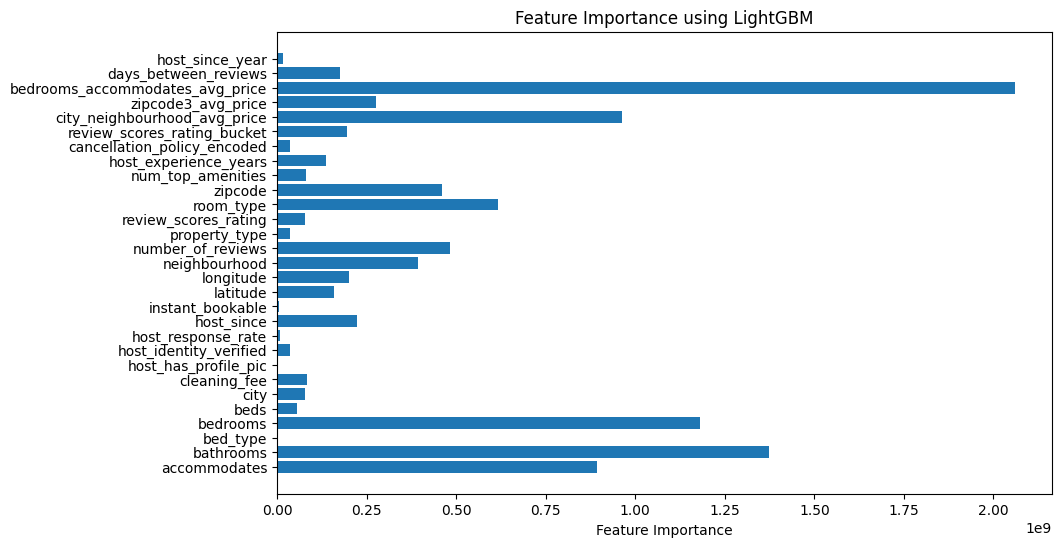

In [ ]:
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 保存用のディレクトリ作成
save_dir = '/content/drive/My Drive/models/'
os.makedirs(save_dir, exist_ok=True)

# 最適なパラメータを直接定義
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.04687720659796865,
    'num_leaves': 96,
    'max_depth': 12,
    'min_data_in_leaf': 30,
    'feature_fraction': 0.7001643980011547,
    'bagging_fraction': 0.9983484799901237,
    'bagging_freq': 5,
    'lambda_l1': 0.09056640064142121,
    'lambda_l2': 0.9339653695428188,
    'seed': 42
}

# データを訓練データと検証データに分割（80%: 訓練, 20%: 検証）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMデータセットの作成
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

# コールバックの設定（過学習防止のためearly_stopping_roundsを適用）
callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True),
    lgb.log_evaluation(period=100)  # 100イテレーションごとにログ表示
]

# モデルのトレーニング（verbose_evalをcallbacksで管理）
final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_val],
    callbacks=callbacks
)

# **RMSEの計算**
y_pred = final_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"\nFinal RMSE on validation set: {rmse:.4f}")

# モデルの保存
model_path = os.path.join(save_dir, 'lgbm_final_model_0111_1.txt')
final_model.save_model(model_path)
print(f"モデルが正常に保存されました: {model_path}")

# 特徴量重要度の可視化
feature_importance_values = final_model.feature_importance(importance_type='gain')
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance_values)
plt.xlabel('Feature Importance')
plt.title('Feature Importance using LightGBM')
plt.show()
